In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, fbeta_score, plot_confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from sklearn import metrics

In [2]:
trainingData = pd.read_csv('Data/TRAIN_ExtractedFeatures&LABEL.csv')
X = trainingData.loc[:, trainingData.columns != 'LABEL']
y = trainingData['LABEL']

In [10]:
#CALCULO DE MEDIA DE LAS METRICAS SOBRE TODAS LAS PARTICIONES CROSS VALIDATION

cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=10)
scoring = {"recall": "recall","precision":"precision", "f4": make_scorer(fbeta_score,beta=4)}

#NORMAL TRAINING
pipeline = make_pipeline(StandardScaler(), SVC(C=1, kernel='rbf',class_weight='balanced')) 
#class_weight='balanced' porque si no el desequilbirio impide calcular correctamente las métricas

scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
print('Recall:\n Test:', scores['test_recall'].mean() , '+-', scores['test_recall'].std())
print('Precision:\nTest:', scores['test_precision'].mean(), '+-', scores['test_precision'].std())
print('Puntuación f4:\n Test:', scores['test_f4'].mean(), '+-', scores['test_f4'].std())

Recall:
 Test: 0.6464285714285715 +- 0.11649647450214351
Precision:
Test: 0.23094132389798022 +- 0.06289672071684904
Puntuación f4:
 Test: 0.5803080563628452 +- 0.10210722118854261


In [13]:
#TRAINING WITH SMOTE
model = make_pipeline(StandardScaler(), SVC(C=1, kernel='rbf'))
over = SMOTE(sampling_strategy=1,random_state=10)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)

scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
print('Recall:\n Test:', scores['test_recall'].mean() , '+-', scores['test_recall'].std())
print('Precision:\nTest:', scores['test_precision'].mean(), '+-', scores['test_precision'].std())
print('Puntuación f4:\n Test:', scores['test_f4'].mean(), '+-', scores['test_f4'].std())

Recall:
 Test: 0.7035714285714285 +- 0.09948848769417228
Precision:
Test: 0.44718614718614713 +- 0.11623729306926128
Puntuación f4:
 Test: 0.6771183794787257 +- 0.09318622678700948


In [17]:
#TRAINING WITH UNDERSAMPLING + SMOTE USANDO EL VALOR ANTERIOR
model = make_pipeline(StandardScaler(), SVC(C=1, kernel='rbf'))
over = SMOTE(sampling_strategy=1,random_state=10)
under = RandomUnderSampler(sampling_strategy=0.01,random_state=10)
steps = [('under', under), ('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)

scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
print('Recall:\n Test:', scores['test_recall'].mean() , '+-', scores['test_recall'].std())
print('Precision:\nTest:', scores['test_precision'].mean(), '+-', scores['test_precision'].std())
print('Puntuación f4:\n Test:', scores['test_f4'].mean(), '+-', scores['test_f4'].std())

Recall:
 Test: 0.675 +- 0.06624013211068362
Precision:
Test: 0.3712717622934341 +- 0.09257447546442475
Puntuación f4:
 Test: 0.6397969433862565 +- 0.05891192549851954


In [21]:
#USE CROSS VALIDATION TO FIND BEST C
model = make_pipeline(StandardScaler(), SVC(C=1, kernel='rbf'))
over = SMOTE(sampling_strategy=1,random_state=10)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=10)
scoring = {"recall": "recall","precision":"precision", "f4": make_scorer(fbeta_score,beta=4)}
grid = GridSearchCV(pipeline, param_grid={'model__svc__C':np.linspace(0.4,1.2,5)}, 
                    cv = cv, scoring=scoring,return_train_score=True,refit='f4')

fitted = grid.fit(X,y)

pd.DataFrame(grid.cv_results_)[['mean_test_recall', 'std_test_recall', 'mean_test_precision', 'std_test_precision',
                                'mean_test_f4', 'std_test_f4','params']]

,mean_test_recall,std_test_recall,mean_test_precision,std_test_precision,mean_test_f4,std_test_f4,params
0,0.675000,0.066240,0.257773,0.040842,0.613022,0.048303,{'model__svc__C': 0.4}
1,0.703571,0.099488,0.342462,0.071785,0.659224,0.087877,{'model__svc__C': 0.6}
2,0.703571,0.099488,0.392187,0.094937,0.668242,0.088743,{'model__svc__C': 0.8}
3,0.703571,0.099488,0.447186,0.116237,0.677118,0.093186,{'model__svc__C': 1.0}
4,0.650000,0.160357,0.493074,0.131422,0.636188,0.155528,{'model__svc__C': 1.2}


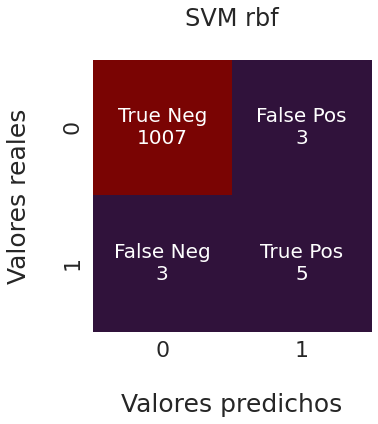

In [26]:
#CONFUSION MATRIX IN TRAINING (en una iteración de la validacion cruzada)

model = make_pipeline(StandardScaler(), SVC(C=1, kernel='rbf'))
over = SMOTE(sampling_strategy=1,random_state=10)
steps = [('over', over), ('model', model)]
clf = Pipeline(steps=steps)
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=10)

for train_index, test_index in cv.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    clf.fit(X_train,y_train)
    y_test = y.iloc[test_index].array
    y_pred = clf.predict(X.iloc[test_index])
    break
    

matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale = 2)
ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='turbo',cbar=False, annot_kws={"size": 20})

ax.set_title('SVM rbf\n')
ax.set_xlabel('\nValores predichos',fontsize=25)
ax.set_ylabel('Valores reales\n',fontsize=25)
sns.set(font_scale=10)

ax.figure.savefig('CM Training/CM_SVM_RBF.png', dpi=1000, bbox_inches="tight")

In [25]:
clf = fitted.best_estimator_
scores = cross_validate(clf, X, y, cv=cv, scoring=scoring)
print('Recall:\n Test:', scores['test_recall'].mean() , '+-', scores['test_recall'].std())
print('Precision:\nTest:', scores['test_precision'].mean(), '+-', scores['test_precision'].std())
print('Puntuación f4:\n Test:', scores['test_f4'].mean(), '+-', scores['test_f4'].std())

Recall:
 Test: 0.7035714285714285 +- 0.09948848769417228
Precision:
Test: 0.44718614718614713 +- 0.11623729306926128
Puntuación f4:
 Test: 0.6771183794787257 +- 0.09318622678700948
